## This notebook for Psychiatric Disorders classification using random forest

### Additional Preprocessing Steps

In [6]:
import pandas as pd
import numpy as np

# load the dataset
data = pd.read_csv('/content/sample_data/md_dataset.csv')

# basic info
print(data.info())
print(data.head())

# class distribution
print(data['main.disorder'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Columns: 1145 entries, sex to main.disorder
dtypes: float64(1145)
memory usage: 8.3 MB
None
        sex       age  education        IQ  delta.FP1  delta.FP2  delta.F7  \
0 -1.301390 -0.458420  -0.582526  0.523944   0.106077   1.049089 -0.001565   
1  0.768409  1.118610   0.966482  0.994871   0.868659   0.575722  0.174696   
2  0.768409  0.188625  -1.744282 -0.064716   2.227206   0.657238  0.923469   
3 -1.301390  2.010524   0.579230 -0.182447  -0.608635  -0.610275 -0.438836   
4  0.768409 -0.937888  -0.195274 -0.653375  -0.310250  -0.398651  0.242929   

   delta.F3  delta.Fz  delta.F4  ...  COH.gamma.Pz.T6  COH.gamma.Pz.O1  \
0  0.292615  0.178098  0.456874  ...         0.400538         0.960893   
1  0.211105  0.314026  0.389149  ...         0.715833         0.171858   
2  1.458520  1.357212  1.317614  ...         0.861778         1.099477   
3 -1.025806 -0.830725 -0.696556  ...        -0.415836        -0.788200 

## without dropping columns

In [ ]:
x_cols = [col for col in data.columns if not col.startswith("main.disorder")]
x_data = data.drop(columns=['main.disorder'])
y_data= data['main.disorder']

## with dropping

In [7]:
# dropping unnecessary columns
new_data=data.drop(columns=["education","IQ","sex","age"])
new_data.head()

x_cols = [col for col in new_data.columns if not col.startswith("main.disorder")]
x_data = new_data[x_cols]
y_data= new_data['main.disorder']

x_data.head()
y_data.head()

,main.disorder
0,4.0
1,3.0
2,3.0
3,6.0
4,5.0


In [8]:
from imblearn.over_sampling import SMOTE
unique_classes = np.unique(y_data)
sampling_strategy = {label: 500 for label in unique_classes}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_balanced, y_balanced = smote.fit_resample(x_data, y_data)

balanced_data = pd.DataFrame(X_balanced, columns=x_cols)
balanced_data['main.disorder'] = y_balanced
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

X_new = balanced_data.drop(columns=['main.disorder']).values
y_new = balanced_data['main.disorder'].values

<ipython-input-8-aa2e33d6b435>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_data['main.disorder'] = y_balanced


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, make_scorer

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators= 100, max_depth=30, min_samples_split=2, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## RESULTS

classification report
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87        99
         1.0       0.94      0.98      0.96        96
         2.0       0.97      0.96      0.96       116
         3.0       0.87      0.77      0.82       101
         4.0       0.99      0.99      0.99        86
         5.0       0.96      0.92      0.94        87
         6.0       0.86      0.94      0.90       115

    accuracy                           0.92       700
   macro avg       0.92      0.92      0.92       700
weighted avg       0.92      0.92      0.92       700

Accuracy: 91.8571


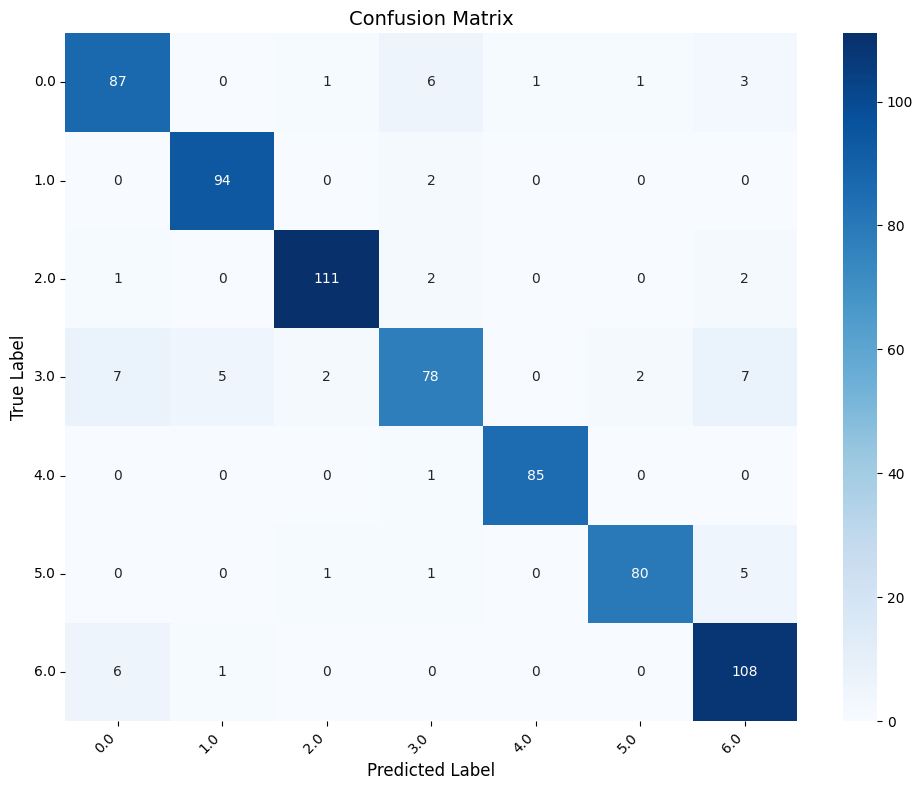

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# classification report
print("classification report")
print(classification_report(y_test, y_pred))

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy *100:.4f}")

conf_mat = confusion_matrix(y_test, y_pred)
class_names = np.unique(y_data)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

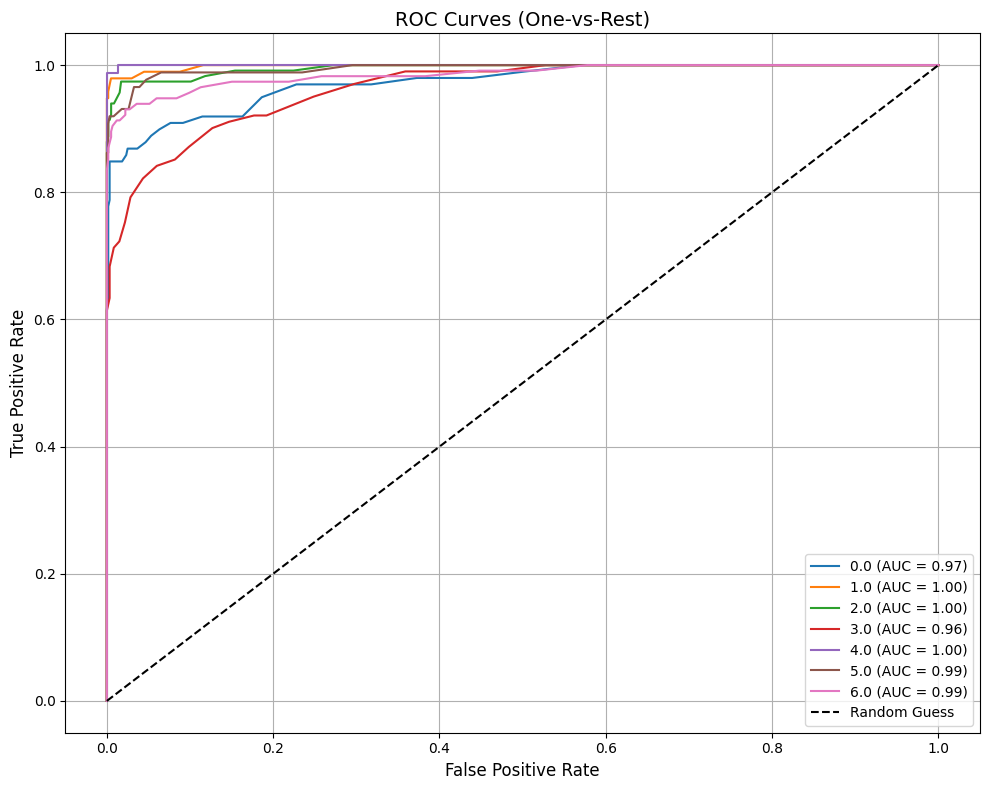

In [89]:
from sklearn.preprocessing import label_binarize

# ROC Curves (for multi-class)
y_test_bin = label_binarize(y_test, classes=class_names)
y_score = model.predict_proba(X_test)

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curves (One-vs-Rest)', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()